In [ ]:
import os, sys, time, re, json, glob
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm import tqdm
import scipy.stats as ss
from functools import reduce
import statsmodels.api as sm
import matplotlib.patheffects as pe

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend_handler import HandlerTuple
from matplotlib import style
style.use('ggplot')
style.use('seaborn-white')

In [3]:
celltype_map = {'Astrocytes': 'Astrocytes',
                'Endothelial.cells': 'Endothelial',
                'Excitatory.neurons': 'Excitatory_neurons',
                'Inhibitory.neurons': 'Inhibitory_neurons',
                'Microglia': 'Microglia',
                'Oligodendrocytes': 'Oligodendrocytes',
                'OPCs...COPs': 'OPCs',
                'Pericytes': 'Pericytes'}
sorted_cell_types = ['Excitatory_neurons', 'Inhibitory_neurons', 'Astrocytes', 'Oligodendrocytes',
                     'Microglia', 'OPCs', 'Endothelial', 'Pericytes']

# Results
Script for running IBSEP: scripts/run_blood.sh

## Combine results

In [ ]:
## combine genes by chrom: sc and ibsep
hij_pval_thres = 1e-10
t0 = time.time()
for chrom in range(1, 23):
    for cell_type in celltype_map.values():
        files = glob.glob(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/*_{cell_type}_IBSEP_truncorr_pval1e-10.csv')
        gene_ids = [x.split('/')[-1].split('_')[0] for x in files if x.split('/')[-1].split('_')[0].startswith('ENSG')]
        dfs = []
        for i, gene_id in tqdm(enumerate(gene_ids)):
            df = pd.read_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_{cell_type}_IBSEP_truncorr_pval1e-10.csv', sep='\t')
            df = df[['CHR', 'BP', 'A1', 'A2', 'SNP', 'GENEID', 'BETA', 'SE', 'PVAL', 'BETA_BLUE', 'SE_BLUE', 'PVAL_BLUE']]
            df.columns = ['CHR', 'BP', 'A1', 'A2', 'SNP_SC', 'GENEID_SC', 'BETA_SC', 'SE_SC', 'PVAL_SC', 'BETA_BLUE', 'SE_BLUE', 'PVAL_BLUE']
            dfs.append(df)
        dfs = pd.concat(dfs)
        dfs.to_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/allgenes_{cell_type}_eqtl_and_IBSEP_truncorr_pval1e-10.csv', sep='\t', index=False)
        print(f'CHR {chrom} {cell_type}: dfs {dfs.shape}.')
t1 = time.time()
print(f'Time: {t1 - t0:.1f}s')

In [ ]:
## combine chroms: sc and ibsep
for cell_type in celltype_map.values():
    dfs = []
    for chrom in tqdm(range(1, 23)):
        df = pd.read_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/allgenes_{cell_type}_eqtl_and_IBSEP_truncorr_pval1e-10.csv', sep='\t')
        dfs.append(df)
    dfs = pd.concat(dfs)
    l0 = len(dfs)
    x = dfs.isnull().any(axis=1)
    dfs_nonnan = dfs.loc[x==False]
    l1 = len(dfs_nonnan)
    dfs_nonnan.to_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/allchroms_{cell_type}_eqtl_and_IBSEP_truncorr_pval1e-10.csv', sep='\t', index=False)
    print(f'{cell_type}: {l0} remove nan -> {l1}')

## eGenes comparison

In [ ]:
stats_highres = {'SC vs SC-Blue':
                 {'Shared genes': {}, 'Only SC genes': {}, 'Only SC-Blue genes': {}},
                 'SC vs GTEx':
                 {'Shared genes': {}, 'Only SC genes': {}, 'Only GTEx genes': {}},
                 'SC-Blue vs GTEx':
                 {'Shared genes': {}, 'Only SC-Blue genes': {}, 'Only GTEx genes': {}}
                }
genes_by_subcell_data = {}
for cell_type in celltype_map.values():
    genes_by_subcell_data[cell_type] = {'SC-Brain': [], 'SC-Brain-IBSEP': [], 'GTEx': []}
pval_thres = 1e-5
t0 = time.time()
for cell_type in celltype_map.values():
    print(f'*** {cell_type} ***')
    df1 = pd.read_csv(f'../data/brain_data/merged_sumstats/{cell_type}.txt.gz', sep='\t', compression='gzip')
    df2 = pd.read_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/allchroms_{cell_type}_eqtl_and_IBSEP_truncorr_pval1e-10.csv', sep='\t')
    merged = pd.merge(df1, df2, on=['SNP_SC', 'GENEID_SC'], how='inner')
    print(f'df1 {len(df1)}, df2 {len(df2)}, merged {len(merged)}')

    ## significance overlap
    sig_1m = merged.loc[merged.PVAL_SC_x < pval_thres]
    sig_blue = merged.loc[merged.PVAL_BLUE < pval_thres]
    sig_gtex = merged.loc[merged.PVAL_GTEX < pval_thres]
    # sig genes
    sig_1m_genes = np.unique(sig_1m.GENEID_SC.values)
    sig_blue_genes = np.unique(sig_blue.GENEID_SC.values)
    sig_gtex_genes = np.unique(sig_gtex.GENEID_SC.values)
    # save sig genes
    genes_by_subcell_data[cell_type]['SC-Brain'] = sig_1m_genes
    genes_by_subcell_data[cell_type]['SC-Brain-IBSEP'] = sig_blue_genes
    genes_by_subcell_data[cell_type]['GTEx'] = sig_gtex_genes

    sig_common_genes = np.intersect1d(sig_1m_genes, sig_blue_genes)
    sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_blue_genes)
    sig_only_blue_genes = np.setdiff1d(sig_blue_genes, sig_1m_genes)
    stats_highres['SC vs SC-Blue']['Shared genes'][cell_type] = sig_common_genes
    stats_highres['SC vs SC-Blue']['Only SC genes'][cell_type] = sig_only_1m_genes
    stats_highres['SC vs SC-Blue']['Only SC-Blue genes'][cell_type] = sig_only_blue_genes
    print(f'SC vs SC-Blue | Common: {len(sig_common_genes)}, Only SC: {len(sig_only_1m_genes)}, Only SC-Blue: {len(sig_only_blue_genes)}')

    sig_common_genes = np.intersect1d(sig_1m_genes, sig_gtex_genes)
    sig_only_1m_genes = np.setdiff1d(sig_1m_genes, sig_gtex_genes)
    sig_only_gtex_genes = np.setdiff1d(sig_gtex_genes, sig_1m_genes)
    stats_highres['SC vs GTEx']['Shared genes'][cell_type] = sig_common_genes
    stats_highres['SC vs GTEx']['Only SC genes'][cell_type] = sig_only_1m_genes
    stats_highres['SC vs GTEx']['Only GTEx genes'][cell_type] = sig_only_gtex_genes
    print(f'SC vs GTEx | Common: {len(sig_common_genes)}, Only SC-Blue: {len(sig_only_1m_genes)}, Only GTEx: {len(sig_only_gtex_genes)}')

    sig_common_genes = np.intersect1d(sig_blue_genes, sig_gtex_genes)
    sig_only_blue_genes = np.setdiff1d(sig_blue_genes, sig_gtex_genes)
    sig_only_gtex_genes = np.setdiff1d(sig_gtex_genes, sig_blue_genes)
    stats_highres['SC-Blue vs GTEx']['Shared genes'][cell_type] = sig_common_genes
    stats_highres['SC-Blue vs GTEx']['Only SC-Blue genes'][cell_type] = sig_only_blue_genes
    stats_highres['SC-Blue vs GTEx']['Only GTEx genes'][cell_type] = sig_only_gtex_genes
    print(f'SC-Blue vs GTEx | Common: {len(sig_common_genes)}, Only SC-Blue: {len(sig_only_blue_genes)}, Only GTEx: {len(sig_only_gtex_genes)}\n')

t1 = time.time()
print(f'Total time: {t1 - t0:.1f}s')

In [16]:
## save egene names
genes_by_cell_data = {}
for k, v in genes_by_subcell_data.items():
    tmp = {}
    for k2, v2 in v.items():
        tmp[k2] = v2.tolist()
    genes_by_cell_data[k] = tmp
with open(f'../data/brain_data/merged_sumstats/by_chrom_gene/lowres_egenes_{pval_thres}_truncorr_1e-10.json', 'w') as f:
    json.dump(genes_by_cell_data, f)

In [10]:
## load egene names
with open(f'../data/brain_data/merged_sumstats/by_chrom_gene/lowres_egenes_1e-05_truncorr_1e-10.json', 'r') as f:
    genes_by_cell_data = json.load(f)

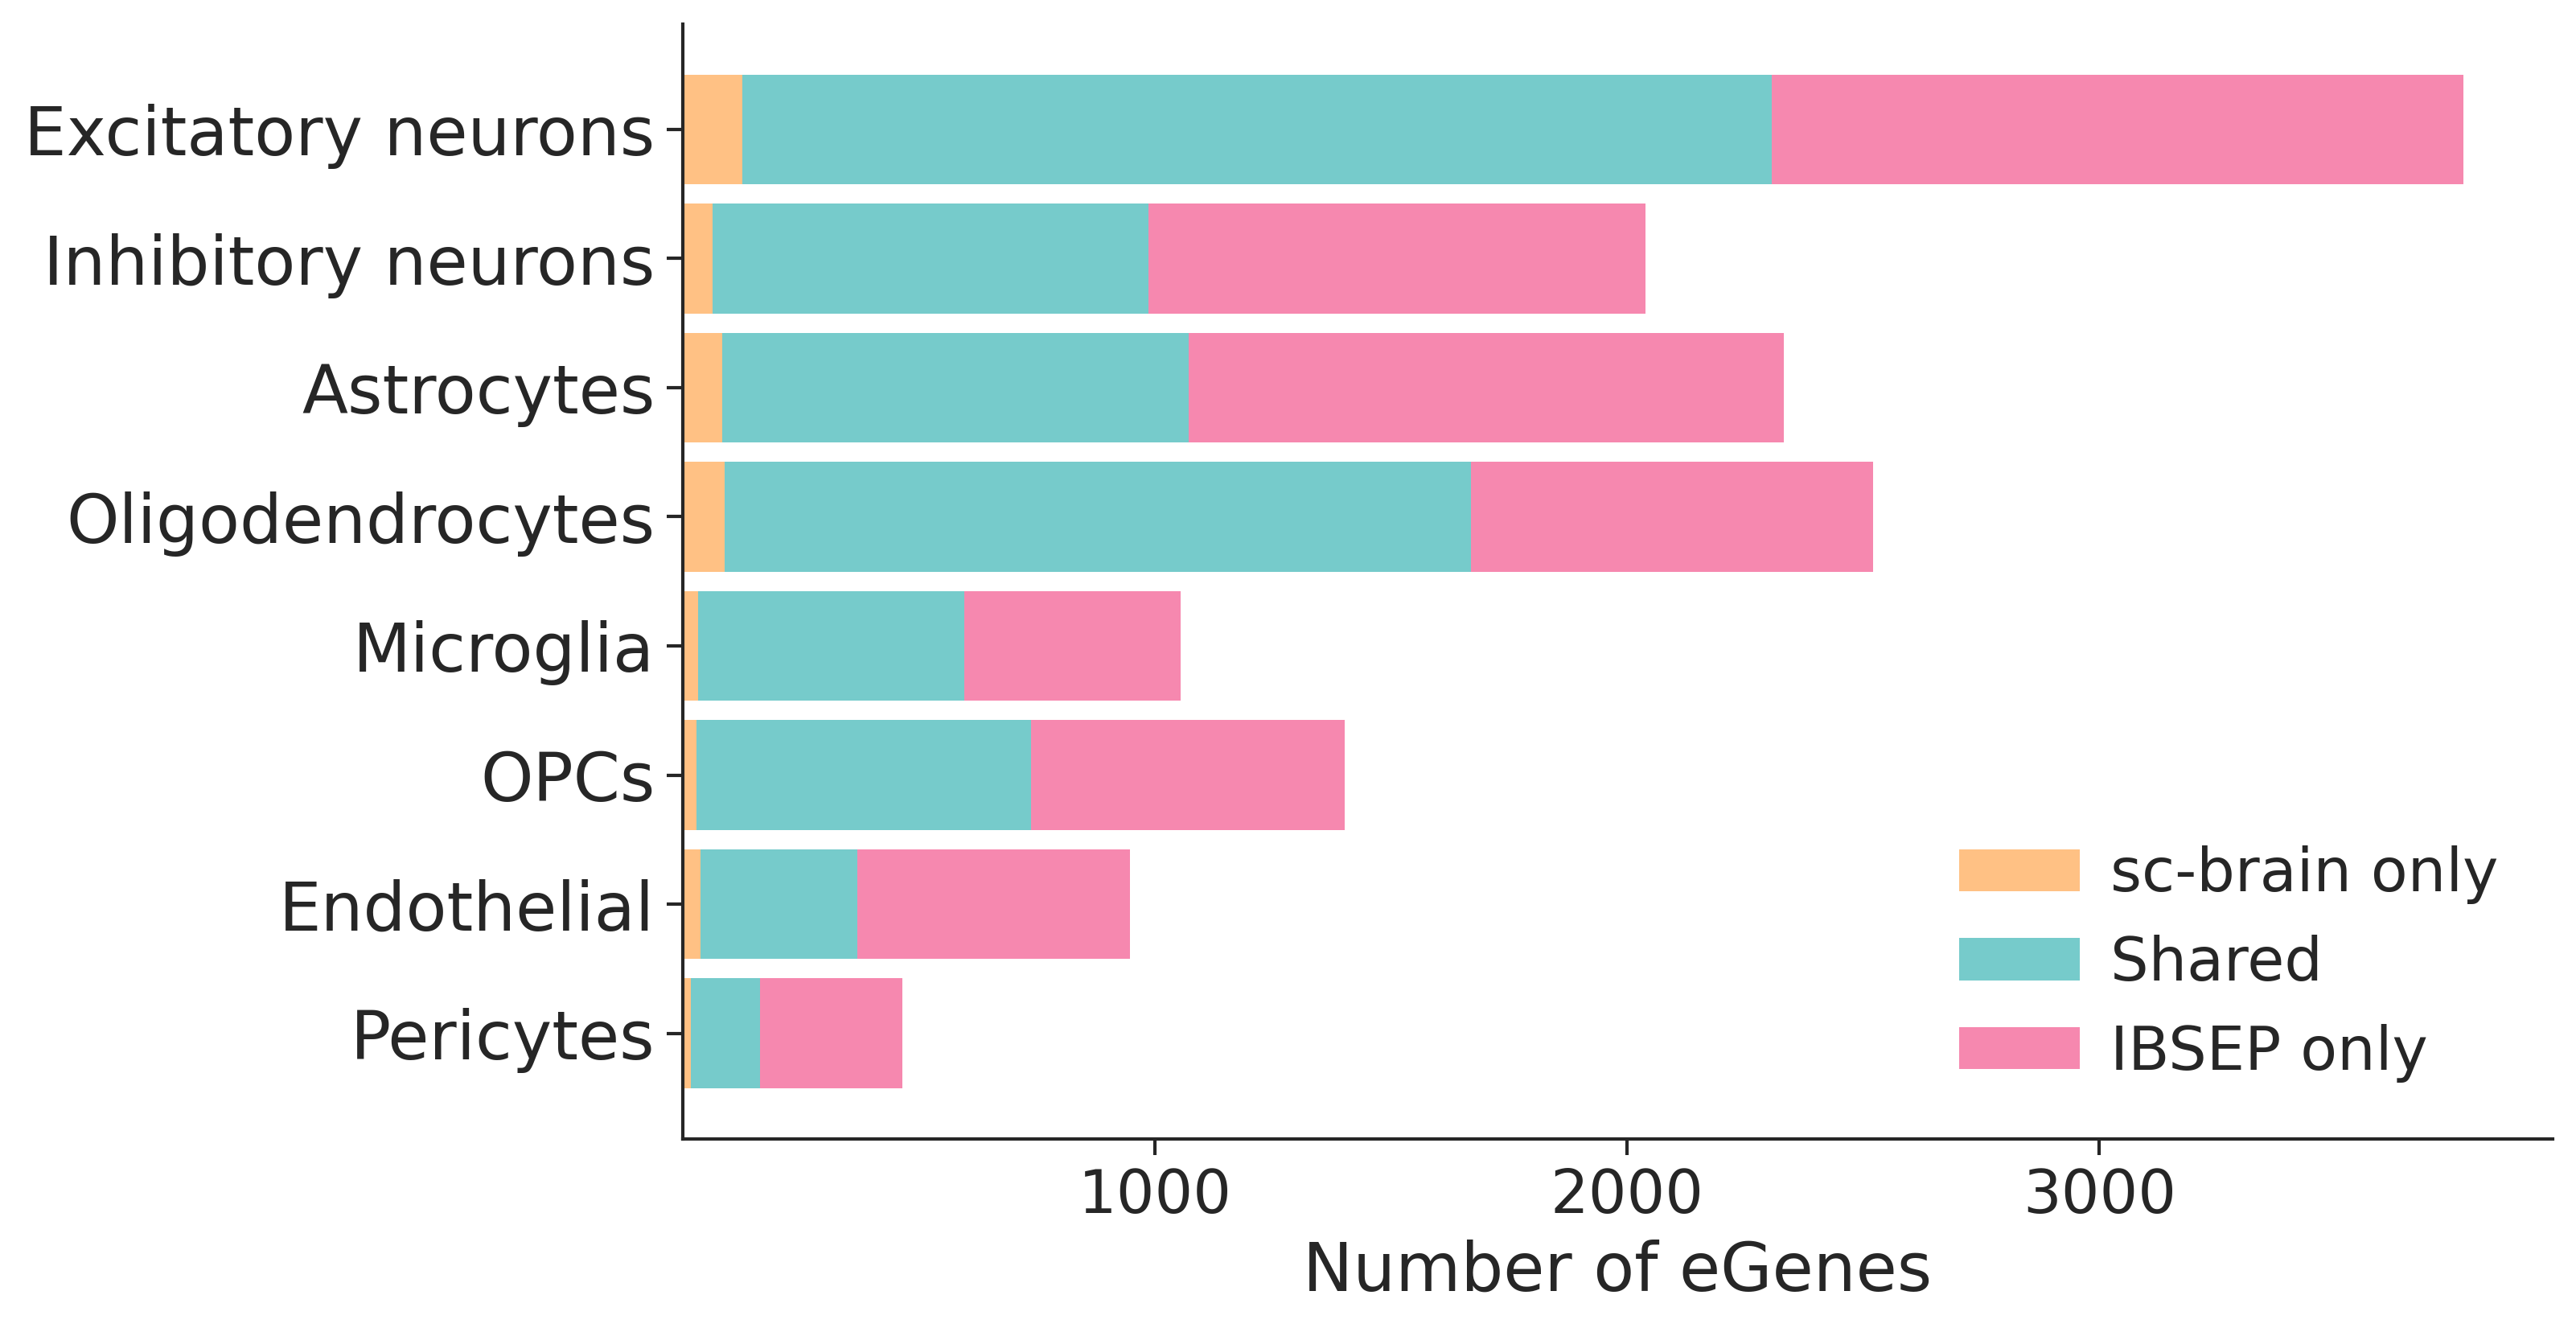

In [52]:
## total egene comparison
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=300, gridspec_kw={'wspace': 0.05})
h = 0.85
alpha1 = 0.8
alpha2 = 0.8
alpha3 = 0.8
c1 = '#ffb266'
c2 = '#54bebe'
c3 = '#f46a9b'

cmap = mpl.cm.get_cmap('Paired')
bar1s, bar2s, bar3s = [], [], []
for i, k in enumerate(sorted_cell_types):
    x = genes_by_cell_data[k]['SC-Brain']
    y = genes_by_cell_data[k]['SC-Brain-IBSEP']
    miss = list(set(x) - set(y))
    share = list(set(x) & set(y))
    novel = list(set(y) - set(x))
    bar1 = ax.barh(i, width=len(miss), height=h, color=c1, alpha=alpha1)
    bar2 = ax.barh(i, width=len(share), height=h, color=c2, alpha=alpha2, left=len(miss))
    bar3 = ax.barh(i, width=len(novel), height=h, color=c3, alpha=alpha3, left=len(miss)+len(share))
    if i == 0:
        bar1s.append(bar1)
        bar2s.append(bar2)
        bar3s.append(bar3)
ax.invert_yaxis()
ax.set_xticks([1000, 2000, 3000])
ax.set_yticks(np.arange(8))
ax.set_yticklabels([x.replace('_', ' ') for x in sorted_cell_types], fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.set_xlabel('Number of eGenes', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.figlegend(handles=[tuple(bar1s), tuple(bar2s), tuple(bar3s)], 
              labels=["sc-brain only", "Shared", "IBSEP only"], 
             handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=2,
             bbox_to_anchor=(0.9, 0.35), ncol=1, fontsize=18,handletextpad=0.5)

In [26]:
### egenes vs number of cell types
egenes_vs_cts = dict.fromkeys(sorted_cell_types)
all_egenes_1m, all_egenes_ibsep = [], []
for ct in sorted_cell_types:
    all_egenes_1m.extend(egenes_lowres[ct]['SC-Brain'])
    all_egenes_ibsep.extend(egenes_lowres[ct]['SC-Brain-IBSEP'])
all_egenes_1m = list(set(all_egenes_1m))
all_egenes_ibsep = list(set(all_egenes_ibsep))
print(len(all_egenes_1m), len(all_egenes_ibsep))

egenes_vs_cts_1m = {k: [] for k in [1,2,3,4,5,6,7,8]}
egenes_vs_cts_ibsep = {k: [] for k in [1,2,3,4,5,6,7,8]}
for gene in all_egenes_1m:
    n = 0
    for ct in sorted_cell_types:
        if gene in egenes_lowres[ct]['SC-Brain']:
            n += 1
    egenes_vs_cts_1m[n].append(gene)
for gene in all_egenes_ibsep:
    n = 0
    for ct in sorted_cell_types:
        if gene in egenes_lowres[ct]['SC-Brain-IBSEP']:
            n += 1
    egenes_vs_cts_ibsep[n].append(gene)

col1, col2 = [], []
for k, v in egenes_vs_cts_1m.items():
    col1.append(len(v))
for k, v in egenes_vs_cts_ibsep.items():
    col2.append(len(v))
egenes_vs_cts_df = pd.DataFrame({'#cell types': [1,2,3,4,5,6,7,8], 'sc': col1, 'ibsep': col2})
egenes_vs_cts_df

4825 6326


,#cell types,sc,ibsep
0,1,3172,2634
1,2,918,1711
2,3,370,930
3,4,161,483
4,5,130,289
5,6,39,161
6,7,22,84
7,8,13,34


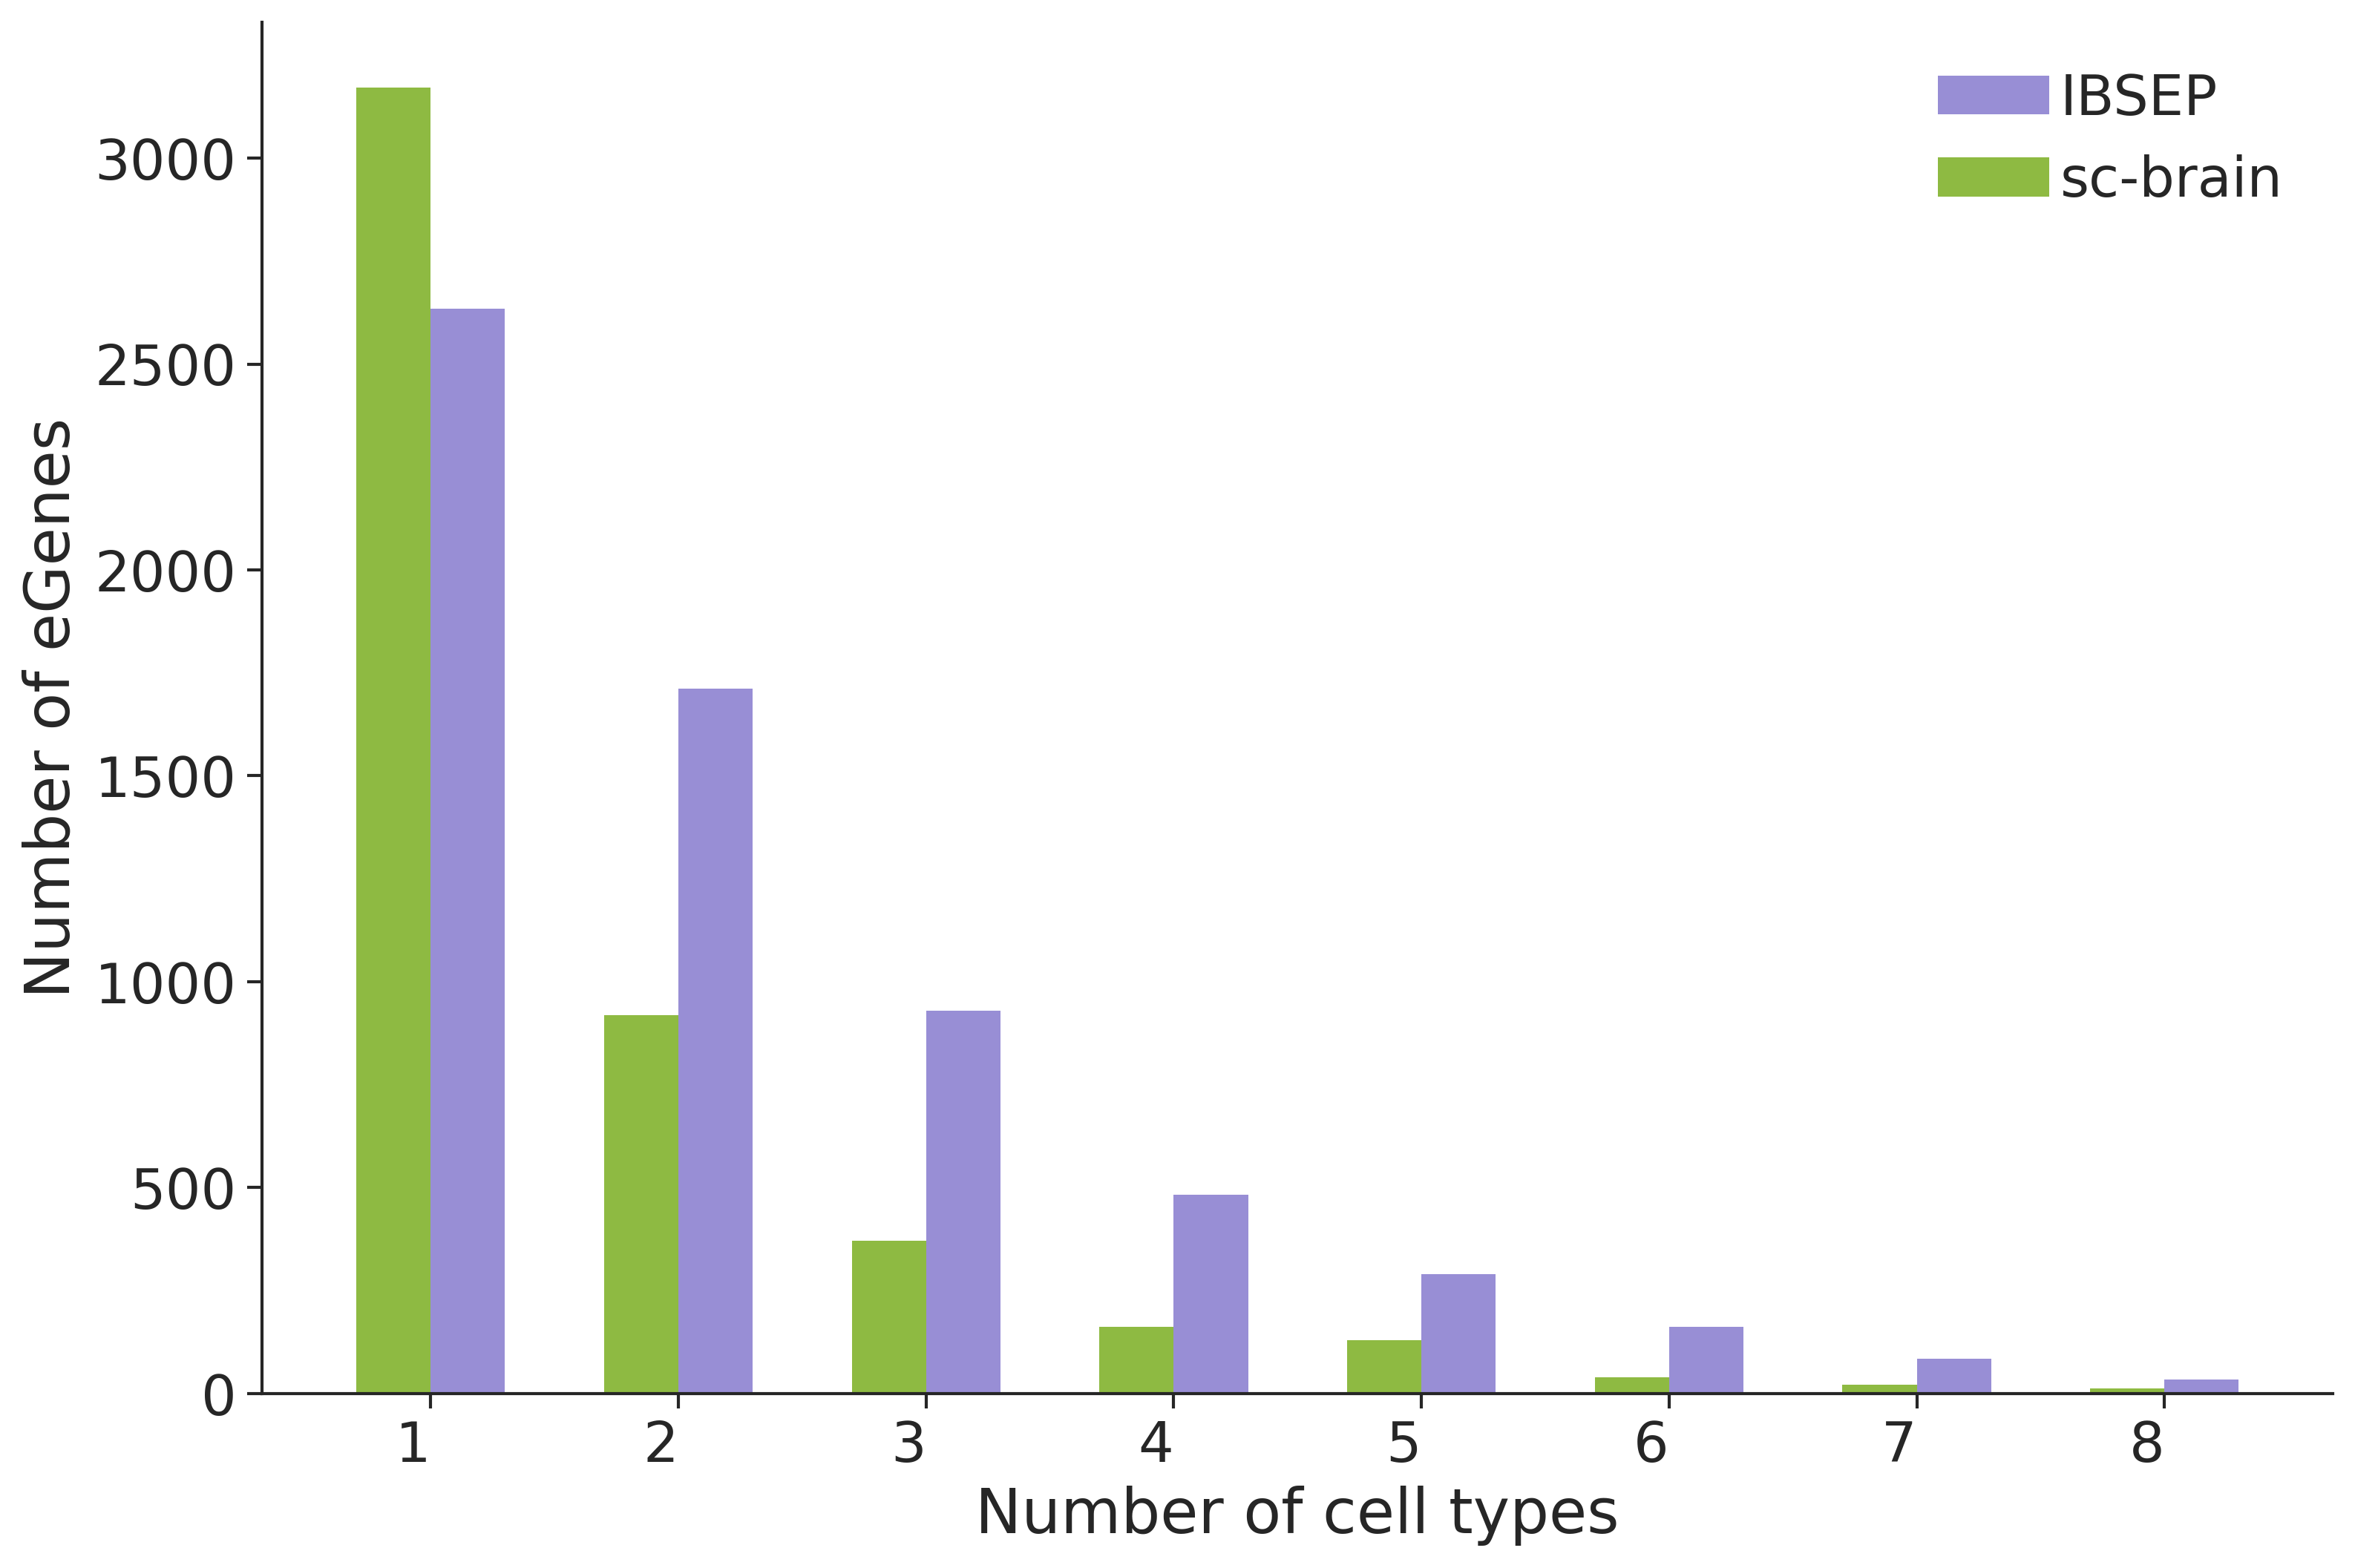

In [101]:
## bar plot: #egenes vs #cell types
style.use('seaborn-white')
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(12, 8), dpi=300)
width = 0.3

bar1 = ax.bar(np.arange(1,9)+0.5*width, egenes_vs_cts_df['ibsep'].values, width=width, color='C2', label='IBSEP')
bar2 = ax.bar(np.arange(1,9)-0.5*width, egenes_vs_cts_df['sc'].values, width=width, color='C5', label='sc-brain')

ax.legend(bbox_to_anchor=(1.0, 1.0),fontsize=18,handletextpad=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number of cell types', fontsize=20)
ax.set_ylabel('Number of eGenes', fontsize=20)
# ax.set_yticks([300, 600, 900, 1200, 1500])
ax.set_xticks([1,2,3,4,5,6,7,8])
ax.set_xticklabels([1,2,3,4,5,6,7,8], rotation=0, ha='right')
ax.tick_params(axis='both', which='major', labelsize=18)
# plt.grid(None)
plt.show()

## Zscore scatter plots

In [101]:
ct = 'Pericytes'
cell_ids = sorted_cell_types.index(ct)
df = pd.read_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/allchroms_{ct}_eqtl_and_IBSEP_truncorr_pval1e-10.csv', sep='\t')
print(df.shape)

(21320375, 12)


In [103]:
### eqtl vs ibsep
## sig
pval_thres = 1e-5
sig_shared = df.loc[(df.PVAL_SC < pval_thres) & (df.PVAL_BLUE < pval_thres)]
sig_only_ibsep = df.loc[(df.PVAL_BLUE < pval_thres) & (df.PVAL_SC >= pval_thres)]
print(sig_shared.shape, sig_only_ibsep.shape)
# both sig
z_sc = sig_shared.BETA_SC.values / sig_shared.SE_SC.values
z_ibsep = sig_shared.BETA_BLUE.values / sig_shared.SE_BLUE.values
print(len(z_sc), len(z_ibsep))
# only ibsep
z_sc2 = sig_only_ibsep.BETA_SC.values / sig_only_ibsep.SE_SC.values
z_ibsep2 = sig_only_ibsep.BETA_BLUE.values / sig_only_ibsep.SE_BLUE.values
print(len(z_sc2), len(z_ibsep2))

(5999, 12) (25912, 12)
5999 5999
25912 25912


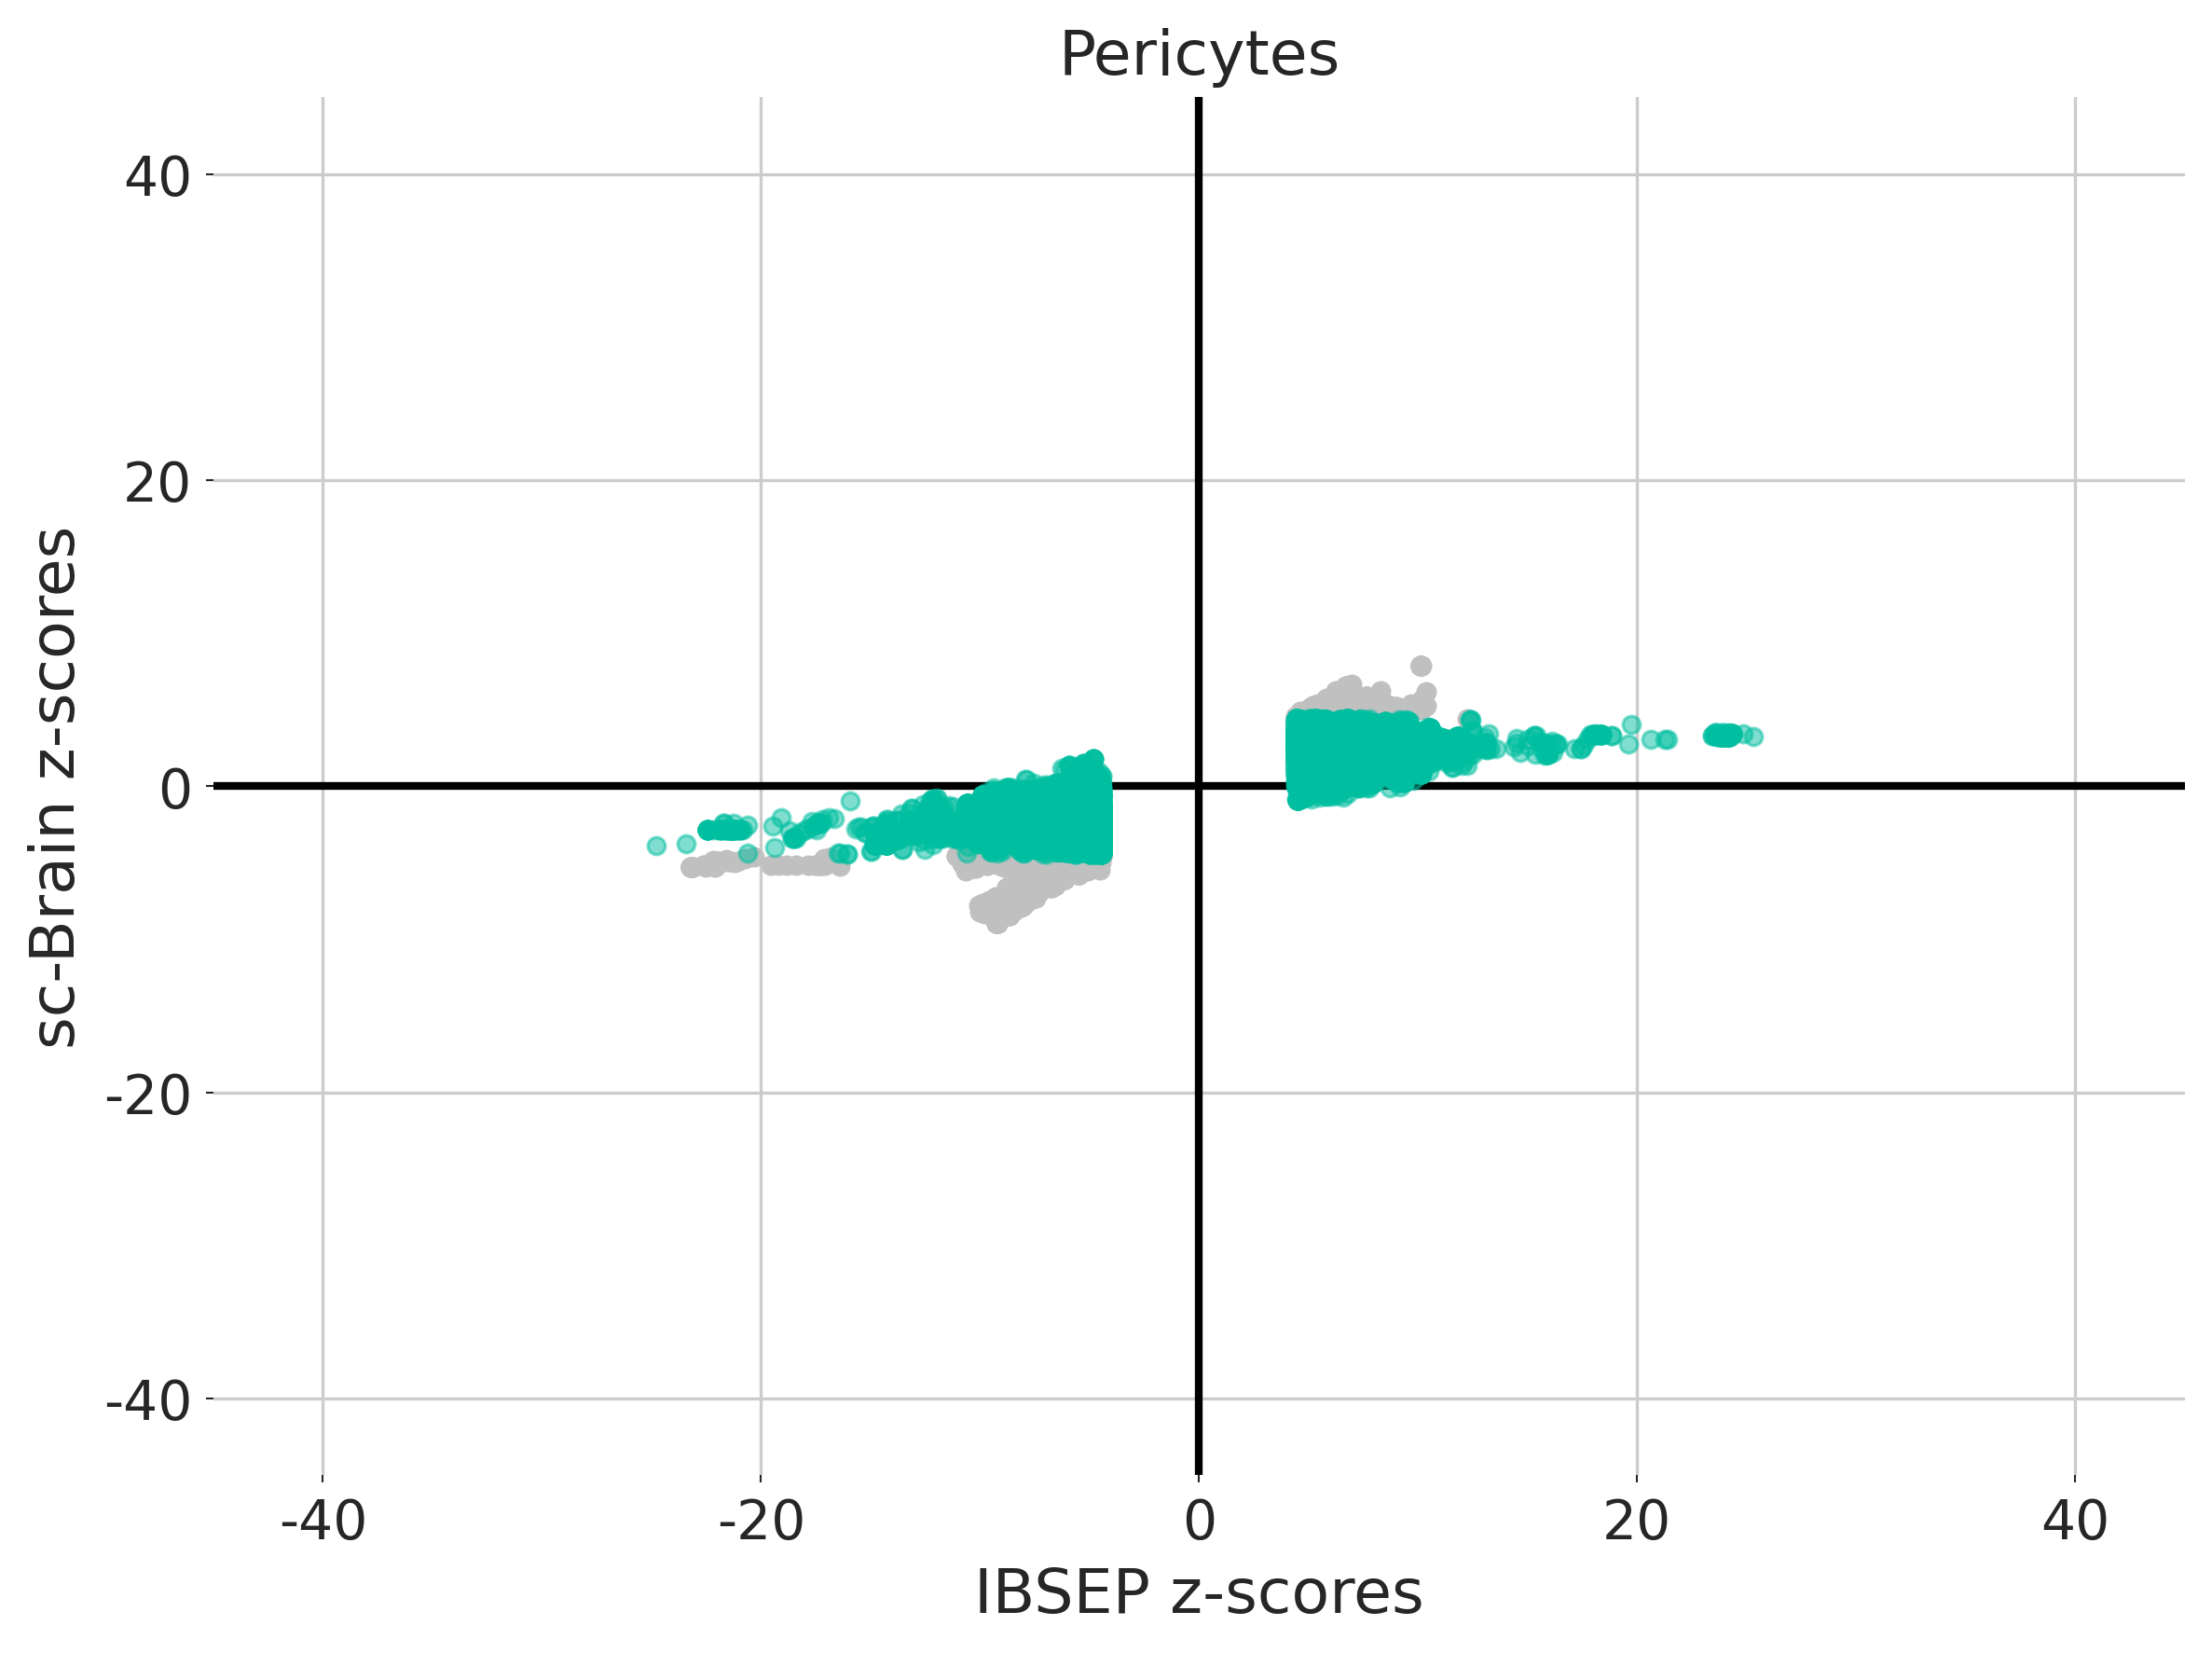

In [104]:
colors = ["#e60049", "#1a53ff", "#51C455", "#9b19f5", "#ffa300", "#dc0ab4", "#66b2ff", "#00bfa0"]
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-whitegrid')
alpha = 0.5
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
c2 = colors[cell_ids]
c1 = '#C0C0C0'
s = 20
ax.scatter(z_ibsep, z_sc, color=c1, s=s)
ax.scatter(z_ibsep2, z_sc2, color=c2, s=s, alpha=alpha)

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)

ax.set_xlabel('IBSEP z-scores', fontsize=label_font)
ax.set_ylabel('sc-Brain z-scores', fontsize=label_font)
ax.set_title(ct.replace('_', ' '), fontsize=title_font)

plt.tight_layout()

## Effective sample size

In [121]:
props_df = pd.read_csv('../cibersortx/cibersortx_8meanprops.csv', sep='\t')
props_df

,cell_type,prop
0,Inhibitory neurons,0.102131
1,Oligodendrocytes,0.169932
2,Excitatory neurons,0.308489
3,Astrocytes,0.290534
4,OPCs,0.003799
5,Microglia,0.049073
6,Pericytes,0.024232
7,Endothelial,0.051812


In [ ]:
corr_method = 'truncorr'
all_cell_types = props_df.cell_type.values.tolist()
all_cell_types = sorted([x.replace(' ', '_') for x in all_cell_types])
N_all, Neff_all, Neff_new_all, Neff_f_all = {k: [] for k in all_cell_types}, {k: [] for k in all_cell_types}, {k: [] for k in all_cell_types}, {k: [] for k in all_cell_types}
n_nonpd = 0
n_hsq = 0
n_total = 0
for chrom in range(1, 23):
    files = glob.glob(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/*gtex.csv')
    gene_ids = [x.split('/')[-1].split('_')[0] for x in files]
    gene_ids = [x for x in gene_ids if x.startswith('ENSG')]
    Ns_, Neffs_, Neff_news_, Neff_fs_ = [], [], [], []
    for gene_id in tqdm(gene_ids):
        est = np.load(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_Omega_blue.npz')
        
        cell_types = est['cell_types']

        Ns, Neffs, Neff_news, Neff_fs = [], [], [], []
        for i, cell_type in enumerate(cell_types):
            try:
                df = pd.read_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_{cell_type}_blue_pval1e-10_tau1_{corr_method}.csv', sep='\t')
                ori = pd.read_csv(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chrom}/{gene_id}_gtex_withld.csv', sep='\t')
                if 'shrinkOmega' in est.files:
                    hsq = np.diag(est['shrinkOmega'])[i]
                    n_nonpd += 1
                else:
                    hsq = np.diag(est['oriOmega'])[i]
                n_total += 1
                if hsq < 1e-2:
                    continue
                n_hsq += 1
                M = len(df)
                if M < 100:
                    continue
                ld_mean = ori.LD.values.mean()
                N = (1 / df.SE ** 2).mean()
    
                Zsq_mean = ((df.BETA / df.SE) ** 2).mean()
                Neff = M * (Zsq_mean - 1) / (hsq * ld_mean)
                Zsq_blue_mean = ((df.BETA_BLUE / df.SE_BLUE) ** 2).mean()
                Neff_new = M * (Zsq_blue_mean - 1) / (hsq * ld_mean)
                Neff_f = (Zsq_blue_mean - 1) / (Zsq_mean - 1)
                if Zsq_mean < 1 or Zsq_blue_mean < 1:
                    continue
    
                N_all[cell_type].append(int(N))
                Neff_all[cell_type].append(int(Neff))
                Neff_new_all[cell_type].append(int(Neff_new))
                Neff_f_all[cell_type].append(Neff_f)
            except Exception as e:
                print(f'Error {e}: {gene_id} {cell_type}')
                continue
    print(f'CHR 1-{chrom}: {n_nonpd} / {n_total}')
    for cell_type in all_cell_types:
        print(f'{cell_type} CHR 1-{chrom}: median Ns {np.median(N_all[cell_type]):.1f}, Neffs {np.median(Neff_all[cell_type]):.1f}, Neff_news {np.median(Neff_new_all[cell_type]):.1f}, Neff_f {np.median(Neff_f_all[cell_type]):.1f}')

In [23]:
sample_sizes = {'N': N_all, 'Neff': Neff_all, 'Neff_new': Neff_new_all, 'Neff_f': Neff_f_all}
with open(f'../brain_data/merged_sumstats/by_chrom_gene/effective_sample_sizes_{corr_method}.json', 'w') as f:
    json.dump(sample_sizes, f)

In [72]:
with open(f'../brain_data/merged_sumstats/by_chrom_gene/effective_sample_sizes_truncorr.json', 'r') as f:
    sample_sizes = json.load(f)

In [73]:
for c in celltype_map.values():
    print(c, np.round(np.percentile(sample_sizes['Neff_f'][c], 10), 2), np.round(np.percentile(sample_sizes['Neff_f'][c], 90), 2))

Astrocytes 0.62 4.66
Endothelial 0.8 3.42
Excitatory_neurons 0.71 3.65
Inhibitory_neurons 0.77 3.8
Microglia 0.85 3.23
Oligodendrocytes 0.72 3.37
OPCs 0.98 3.52
Pericytes 0.89 3.31


In [76]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

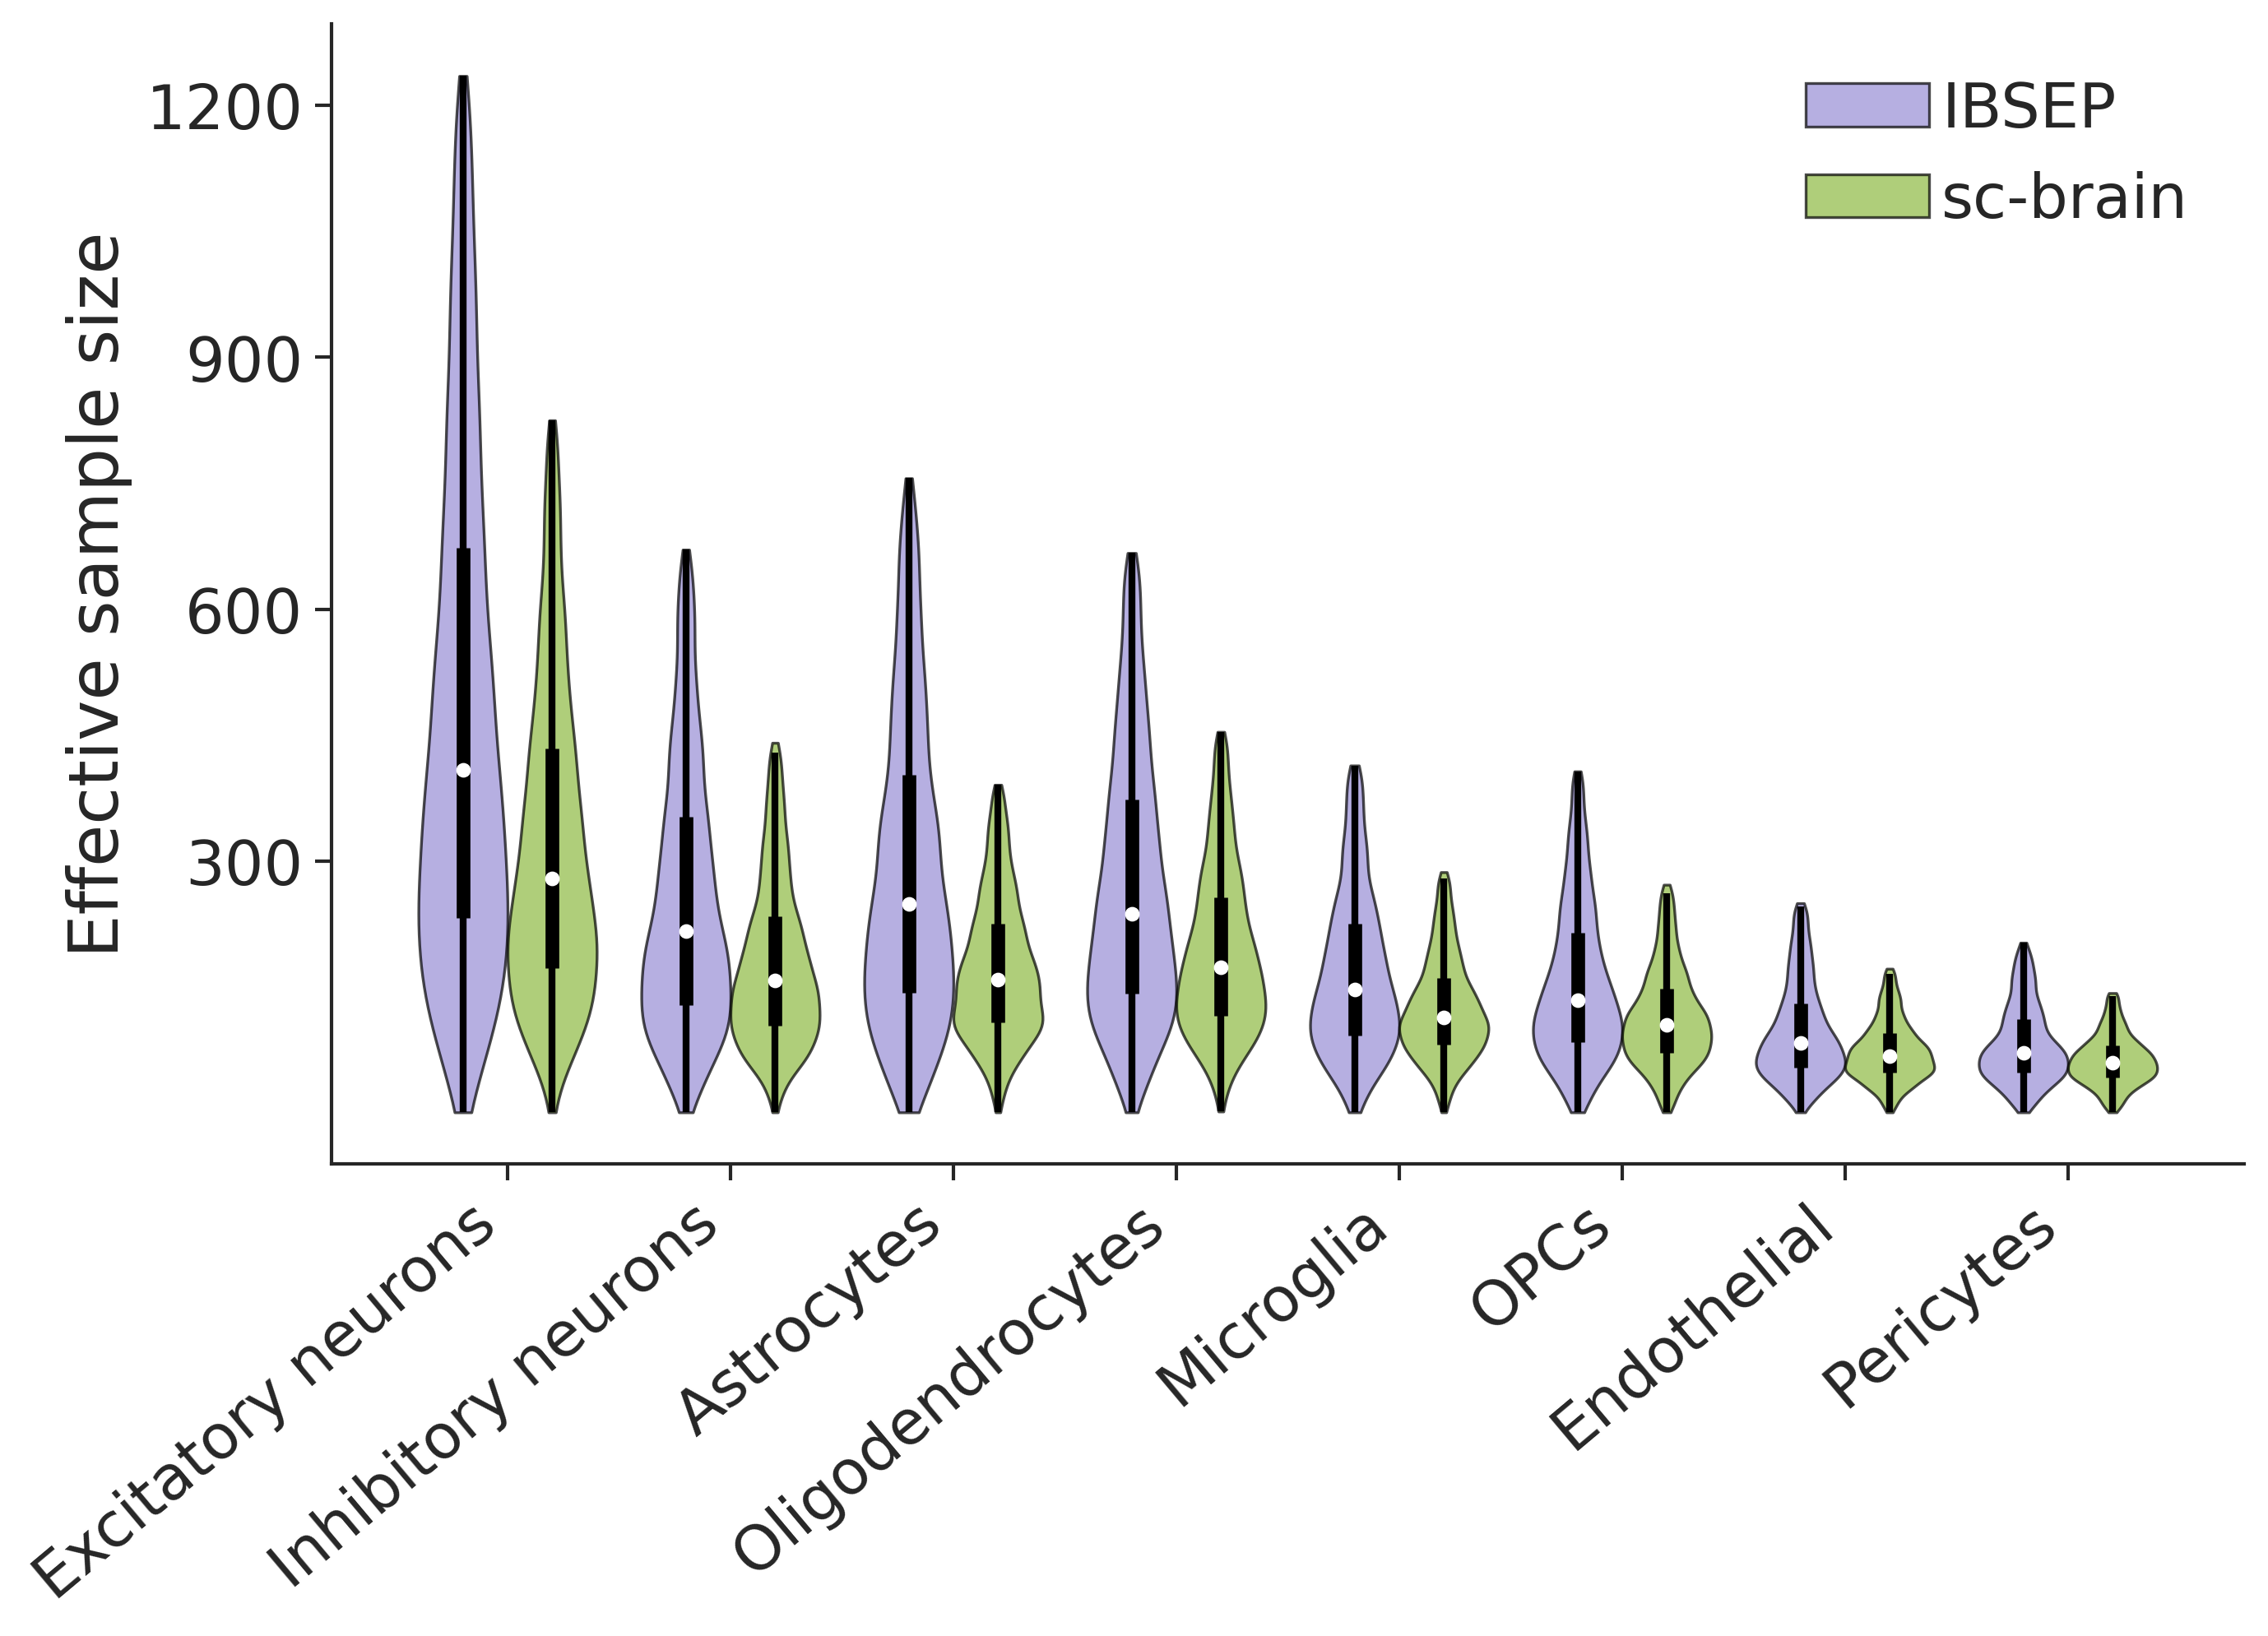

In [81]:
## violin plot
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(10, 6), dpi=300)
width = 0.4

for i, k in enumerate(sorted_cell_types):
    v = sample_sizes['Neff_new'][k]
    v_plot = np.sort(np.array(v)[(np.array(v) > 0) & (v < np.percentile(v, 85))])
    vio1 = ax.violinplot(v_plot, positions=[i-0.5*width], widths=width, showextrema=False, showmedians=False,showmeans=False)
    for pc in vio1['bodies']:
        pc.set_facecolor('C2')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    quartile1, medians, quartile3 = np.percentile(v_plot, [25, 50, 75])
    whiskers = adjacent_values(v_plot, quartile1, quartile3)
    whiskers_min, whiskers_max = whiskers[0], whiskers[1]
    
    ax.scatter([i-0.5*width], [medians], marker='o', color='white', s=12, zorder=4)
    ax.vlines([i-0.5*width], quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines([i-0.5*width], whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

for i, k in enumerate(sorted_cell_types):
    v = sample_sizes['Neff'][k]
    v_plot = np.sort(np.array(v)[(np.array(v) > 0) & (v < np.percentile(v, 90))])
    vio2 = ax.violinplot(v_plot, positions=[i+0.5*width], widths=width, showextrema=False, showmedians=False, showmeans=False)
    for pc in vio2['bodies']:
        pc.set_facecolor('C5')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    quartile1, medians, quartile3 = np.percentile(v_plot, [25, 50, 75])
    whiskers = adjacent_values(v_plot, quartile1, quartile3)
    whiskers_min, whiskers_max = whiskers[0], whiskers[1]
    
    ax.scatter([i+0.5*width], [medians], marker='o', color='white', s=12, zorder=4)
    ax.vlines([i+0.5*width], quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines([i+0.5*width], whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

ax.legend(handles=[vio1["bodies"][0], vio2["bodies"][0]], 
                 labels=["IBSEP", "sc-brain"],
                bbox_to_anchor=(1.0, 1.0),fontsize=18,handletextpad=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Effective sample size', fontsize=20)
ax.set_yticks([300, 600, 900, 1200])
ax.set_xticks(range(8))
ax.set_xticklabels([x.replace('_', ' ') for x in sorted_cell_types], rotation=40, ha='right')
ax.tick_params(axis='both', which='major', labelsize=18)
# plt.grid(None)
plt.show()

In [84]:
X, Y = [], []
for c in sorted_cell_types:
    prop = prop_df.loc[prop_df.cell_type == c.replace('_', ' '), 'prop']
    a = np.array(sample_sizes['Neff_f'][c])
    idx = np.where((a < np.percentile(a, 90)) & (a > np.percentile(a, 10)))[0]
    x = a[idx]
    # print(c, prop, len(idx), len(x))
    X.append(x)
    Y.append(np.repeat(prop, len(x)))
X = np.concatenate(X)
Y = np.concatenate(Y)
print(len(X), len(Y))
X2, Y2 = [], []
for c in sorted_cell_types:
    prop = prop_df.loc[prop_df.cell_type == c.replace('_', ' ')]['prop'].values[0]
    a = np.array(sample_sizes['Neff_f'][c])
    idx = np.where((a < np.percentile(a, 95)) & (a > 0))[0]
    X2.append(np.median(a[idx]))
    Y2.append(prop)

37541 37541


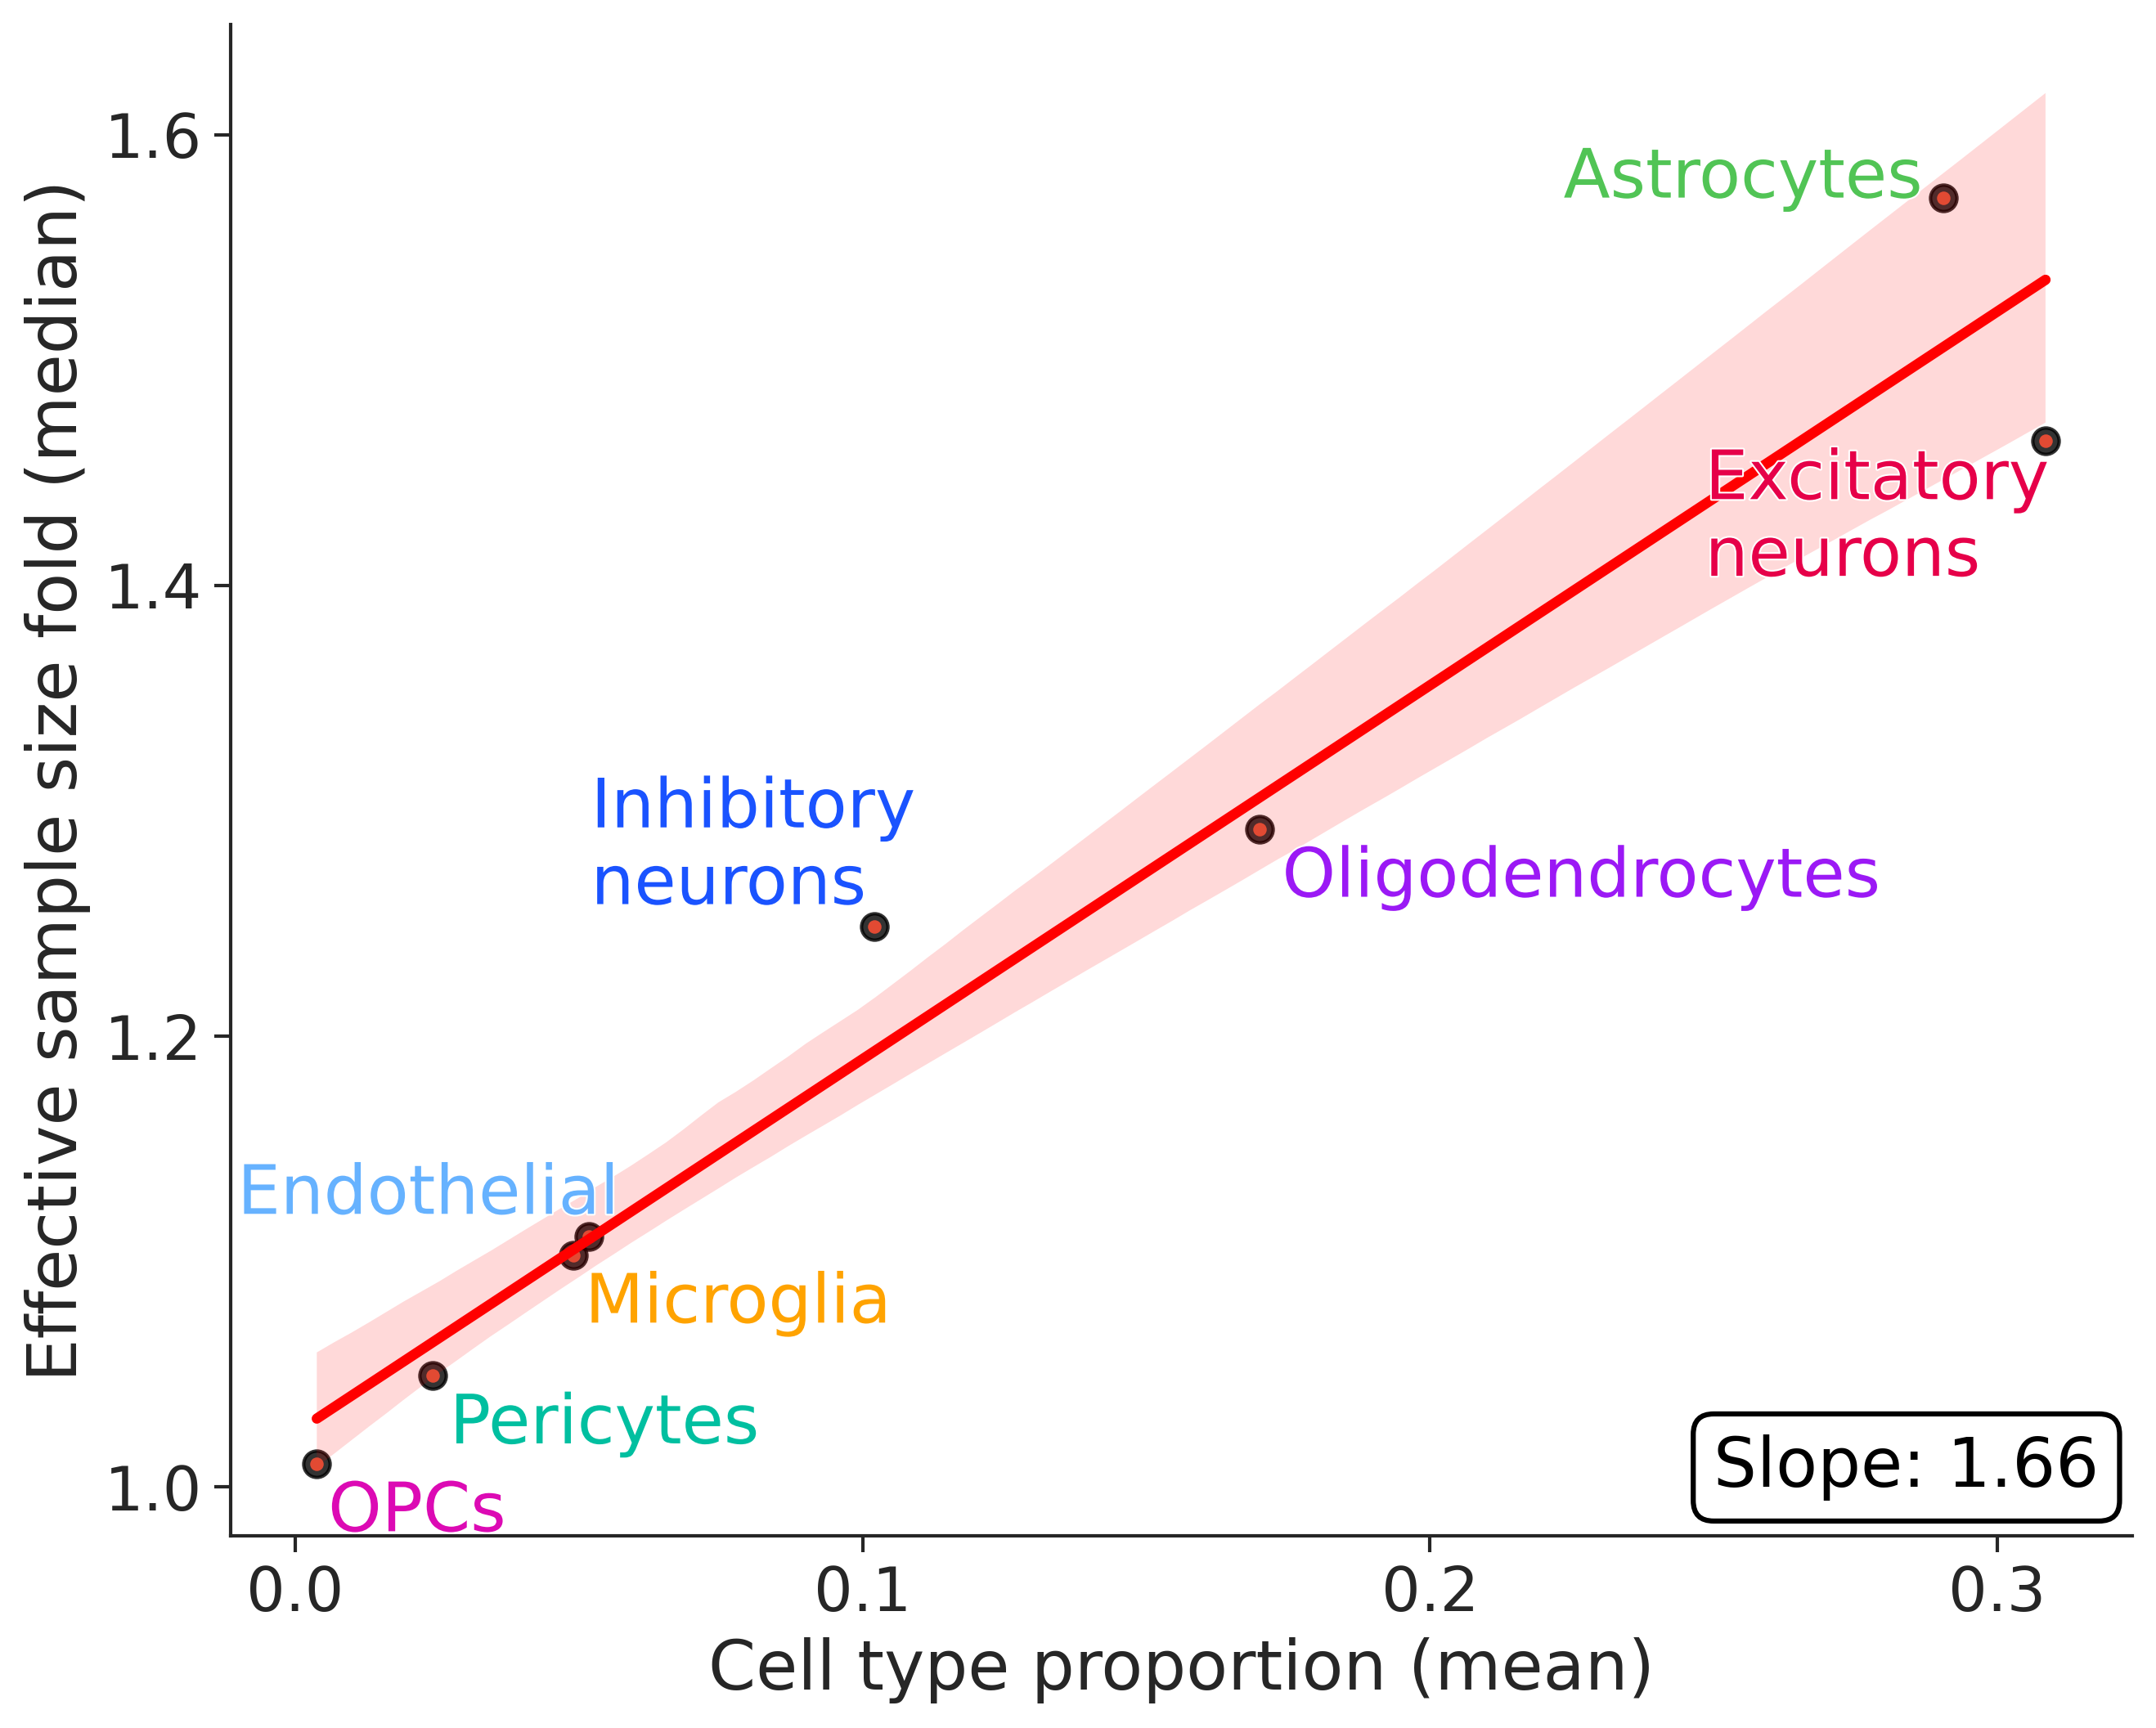

In [98]:
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
preg = sns.regplot(
    x=Y2, y=X2, ci=90, seed=0, n_boot=10000,
    line_kws=dict(color="r", linewidth=3), scatter_kws=dict(color='black', s=60)
)
slope, intercept, r_value, p_value, std_err = ss.linregress(x=preg.get_lines()[0].get_xdata(),y=preg.get_lines()[0].get_ydata())
texts = []
# colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#beb9db", "#fdcce5", "#8bd3c7"]
colors = ["#e60049", "#1a53ff", "#51C455", "#9b19f5", "#ffa300", "#dc0ab4", "#66b2ff", "#00bfa0"]
for i, (y2, x2) in enumerate(zip(Y2, X2)):
    if i == 0:
        y2 = y2 - 0.06
        x2 = x2 - 0.06
    if i == 1:
        y2 = y2 - 0.05
        x2 = x2 + 0.01
    if i == 2:
        y2 = y2 - 0.067
    if i == 3:
        y2 = y2 + 0.004
        x2 = x2 - 0.03
    if i == 4:
        y2 = y2 + 0.002
        x2 = x2 - 0.03
    if i == 5:
        y2 = y2 + 0.002
        x2 = x2 - 0.03
    if i == 6:
        y2 = y2 - 0.062
        x2 = x2 + 0.01
    if i == 7:
        y2 = y2 + 0.003
        x2 = x2 - 0.03
    texts.append(plt.text(x=y2, y=x2, s=list(sorted_cell_types)[i].replace('_', '\n'), 
                          bbox={'facecolor':'none', 'edgecolor':'none', 'pad':10},
                          path_effects=[pe.withStroke(linewidth=1, foreground='w')],
                          fontsize=20, color=colors[i]))
plt.text(x=0.25, y=1., s=f'Slope: {slope:.2f}', fontsize=20, color='black', 
         bbox=dict(boxstyle="round", lw=1.5,
                   ec=(0, 0, 0), fc=(1., 1, 1),
                   ))
ax.scatter(Y2, X2, marker='.', s=40)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 0.1, 0.2, 0.3])
ax.set_yticks([1.0, 1.2, 1.4, 1.6])
ax.set_xlabel('Cell type proportion (mean)', fontsize=20)
ax.set_ylabel('Effective sample size fold (median)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

## Heritability

In [ ]:
hsqs = {k: [] for k in sorted_cell_types}
for chr in tqdm(range(1, 23)):
    files = glob.glob(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chr}/*_Omega_blue.npz')
    for file in files:
        est = np.load(file)
        for i, c in enumerate(est['cell_types']):
            if 'shrinkOmega' in est.files:
                hsqs[c].append(est['shrinkOmega'][i, i])
            else:
                hsqs[c].append(min(est['oriOmega'][i, i], 0.8))
    print(chr, len(files))

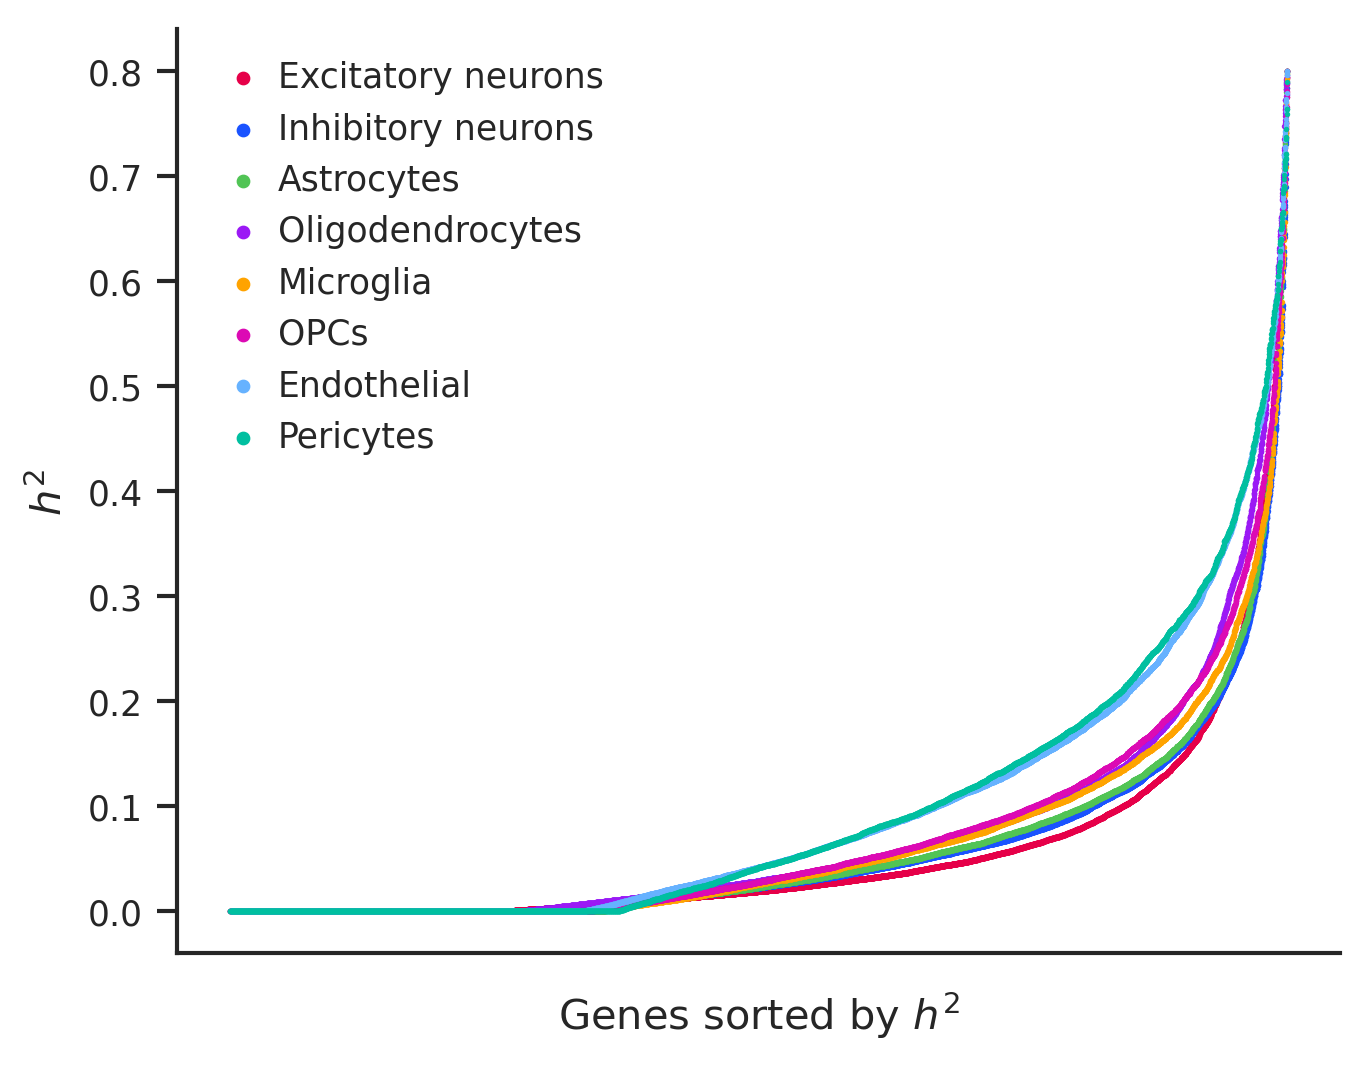

In [59]:
xmax = 10000
sns.set_context('paper',font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
colors = ["#e60049", "#1a53ff", "#51C455", "#9b19f5", "#ffa300", "#dc0ab4", "#66b2ff", "#00bfa0"]
for i, ct in enumerate(hsqs.keys()):
    x = np.array(hsqs[ct])
    x = np.sort(x[np.where((x > 0) & (x < 0.8))])
    ax.scatter(np.linspace(0, xmax, len(x)), x, c=colors[i], marker='.', s=1, label=ct.replace('_', ' '))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('Genes sorted by '+r'$h^2$', fontsize='small')
ax.set_ylabel(r'$h^2$', fontsize='small')
ax.legend(loc='upper left', markerscale=5, fontsize='x-small', handletextpad=0)
ax.tick_params(axis='both', which='major', labelsize='x-small')

## Cell type correlation

In [ ]:
pval_thres = 1e-10
corrs = {}
for c1 in sorted_cell_types:
    for c2 in sorted_cell_types:
        idx1 = sorted_cell_types.index(c1)
        idx2 = sorted_cell_types.index(c2)
        if idx1 < idx2:
            corrs[f'{c1}-{c2}'] = []
for chr in tqdm(range(1, 23)):
    files = glob.glob(f'../data/brain_data/merged_sumstats/by_chrom_gene/chr{chr}/*_Omega_blue.npz')
    print(chr, len(files))
    for file in files:
        est = np.load(file)
        cells = est['cell_types']
        nc = len(cells)
        if nc > 1:
            for i in range(nc):
                c1 = cells[i]
                for j in range(nc):
                    c2 = cells[j]
                    idx1 = sorted_cell_types.index(c1)
                    idx2 = sorted_cell_types.index(c2)
                    if idx1 < idx2:
                        hij_z = est['oriOmega'][i, j] / est['oriOmega_se'][i, j]
                        hij_p = ss.norm.sf(abs(hij_z)) * 2
                        if hij_p < pval_thres:
                            corrs[f'{c1}-{c2}'].append(1)
                        else:
                            corrs[f'{c1}-{c2}'].append(0)

In [392]:
corr_ratio = {}
for k, v in corrs.items():
    if len(v) == 0:
        corr_ratio[k] = 0
    else:
        corr_ratio[k] = sum(v) / len(v)
corr_mat = np.empty((8, 8))
corr_mat.fill(np.nan)
for k, v in corr_ratio.items():
    c1, c2 = k.split('-')
    i = sorted_cell_types.index(c1)
    j = sorted_cell_types.index(c2)
    corr_mat[i, j] = v
masked_array = np.ma.array (corr_mat, mask=np.isnan(corr_mat))

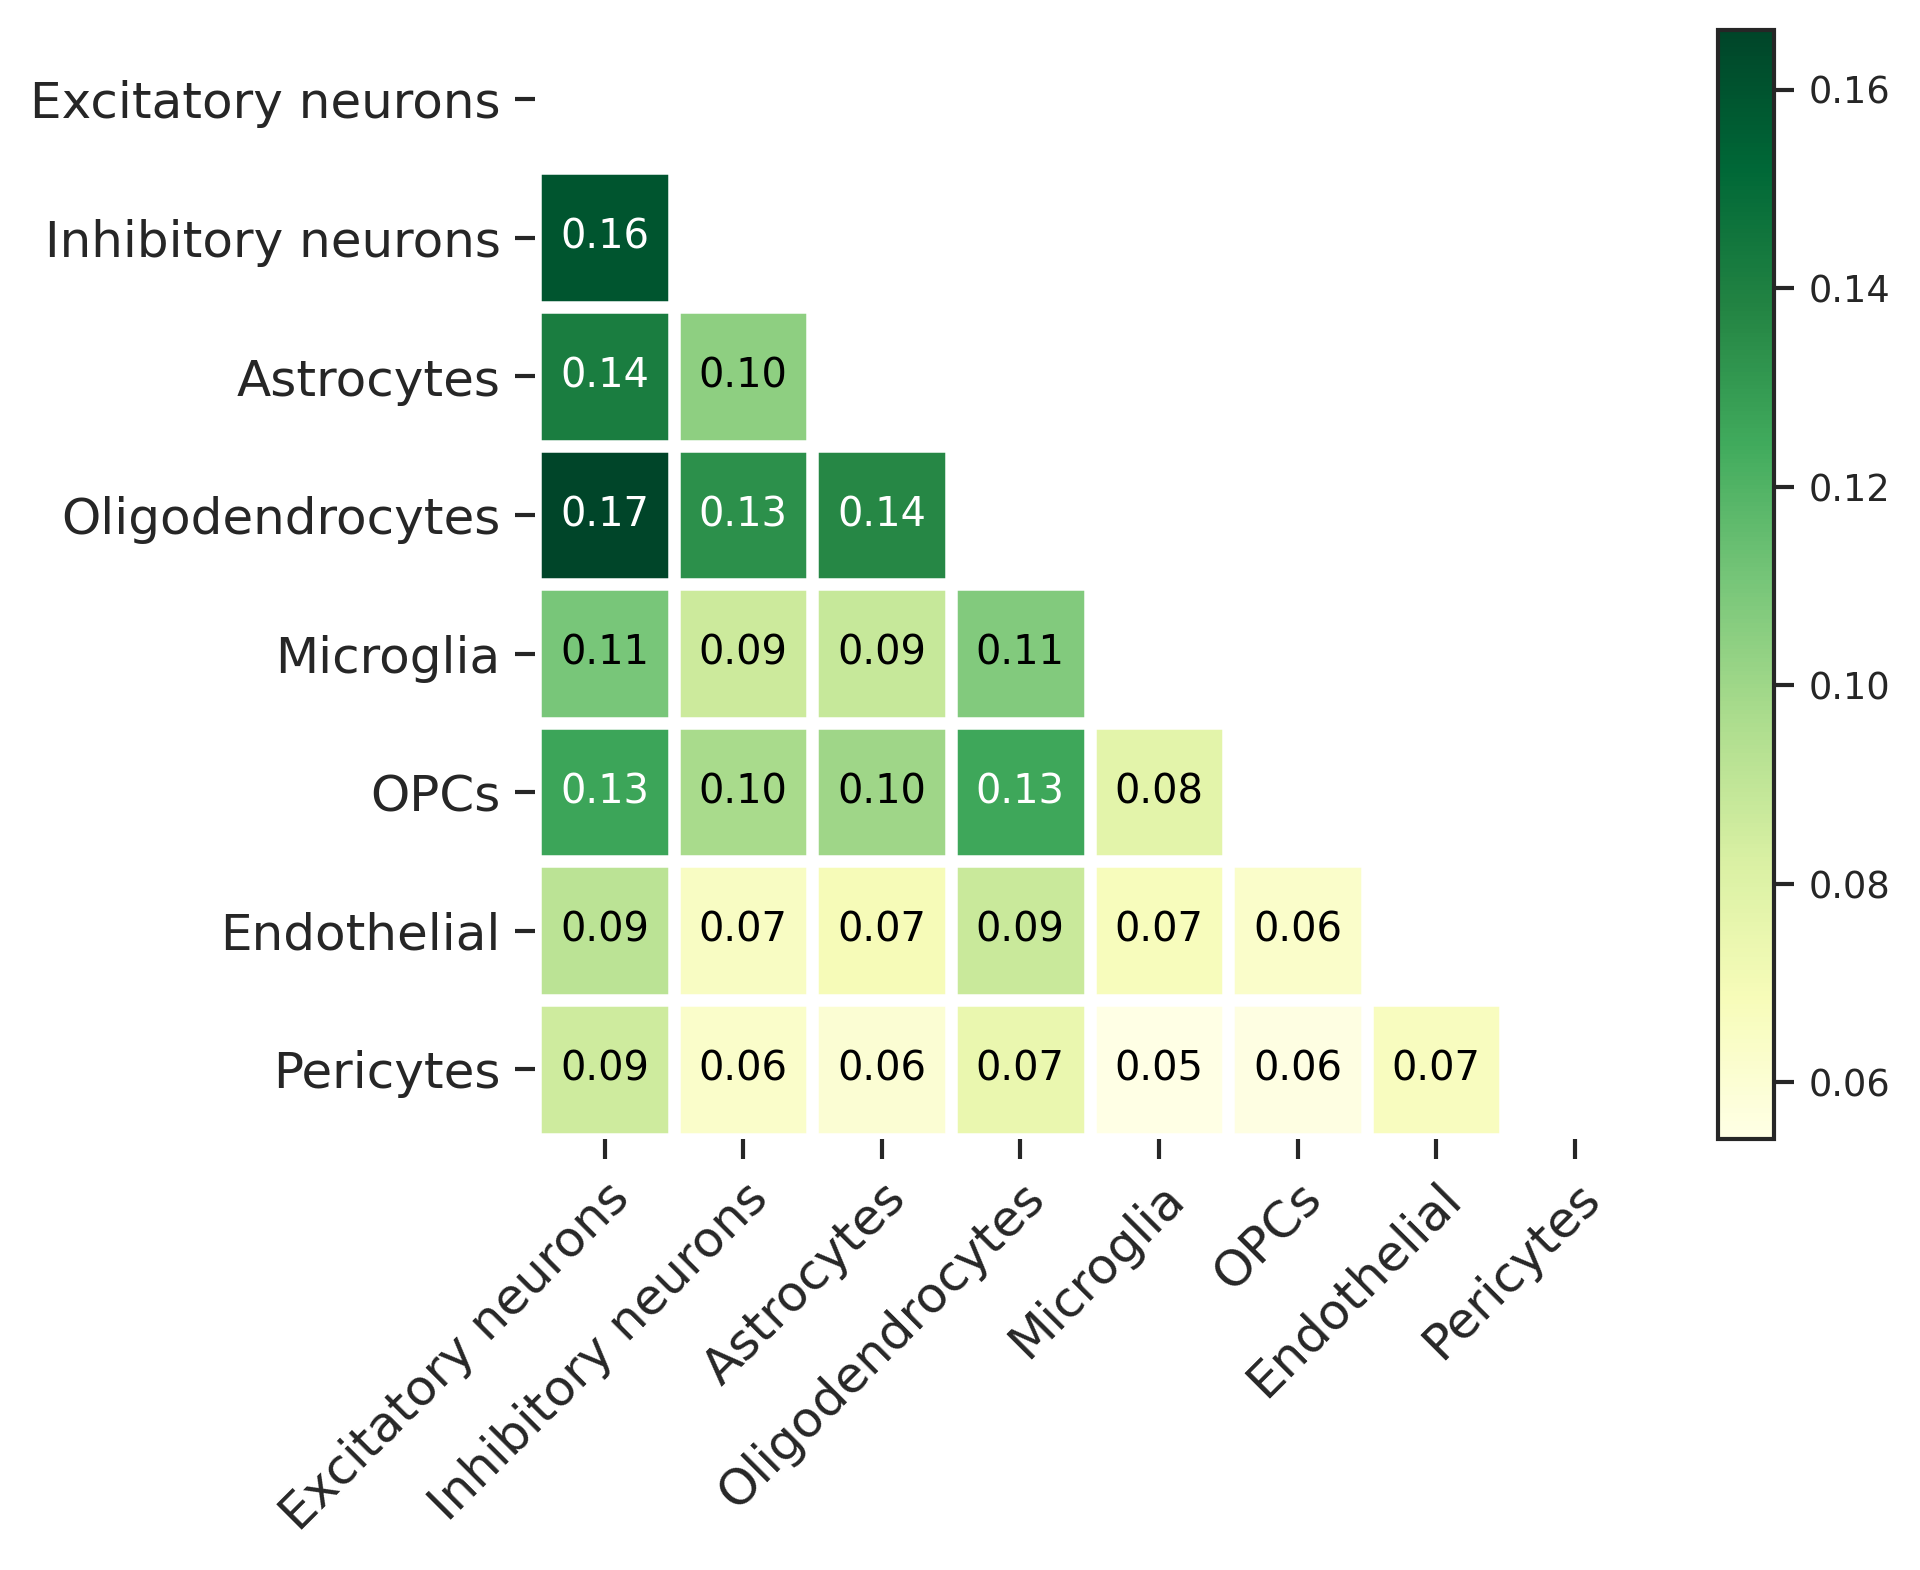

In [394]:
data = masked_array.T
cbarlabel = ''
col_labels = [x.replace('_', ' ') for x in sorted_cell_types]
row_labels = [x.replace('_', ' ') for x in sorted_cell_types]
threshold = None
valfmt="{x:.2f}"
textcolors=("black", "white")

fig, ax = plt.subplots(dpi=300)
# Plot the heatmap
cmap = mpl.cm.YlGn
cmap.set_bad('white',1.)
im = ax.imshow(data, cmap=cmap)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries.
ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=12)
ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=12)

# Let the horizontal axes labeling appear on bottom.
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)

ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

if not isinstance(data, (list, np.ndarray)):
    data = im.get_array()

# Normalize the threshold to the images color range.
if threshold is not None:
    threshold = im.norm(threshold)
else:
    threshold = im.norm(data.max())/2.

# Set default alignment to center, but allow it to be
# overwritten by textkw.
kw = dict(horizontalalignment="center",
          verticalalignment="center")
# kw.update(textkw)

# Get the formatter in case a string is supplied
if isinstance(valfmt, str):
    valfmt = mpl.ticker.StrMethodFormatter(valfmt)

# Loop over the data and create a `Text` for each "pixel".
# Change the text's color depending on the data.
texts = []
for i in range(1, data.shape[0]):
    for j in range(i):
        kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
        texts.append(text)
